# NYC MoMA Artworks - Exploratory Analysis

<section id="toc">
    <h2>Introduction</h2>
</section>

<section id="toc">
    <h2>Table of Contents</h2>
    <ol>
        <li><a href="#intro">Introduction</a></li>
        <li><a href="#load-libaries">Load Libraries</a></li>
        <li><a href="#define-funcs">Defining Data Analysis Functions</a></li>
        <li><a href="#load-data">Load Data</a></li>
        <li><a href="#data-prep">Data Preprocessing</li>
        <li><a href="#data-valid">Data Validation</a></li>
        <li><a href="#desc-stats">Define Data Quality</a></li>
        <li><a href="#ts-analysis">Collections Time Series Analysis</li>
            <ol>
            <li><a href="#acc-and-ts">Accession Analysis & Decomposition</a>
                <ol>
                <li>Credit</li>
                <li>Department</li>
                <li>Storage Group</li>
                <li>Overall</li>
                </ol>
            </li>
            <li><a href="#gap-analysis">Gaps in Acquisition</a></li>
                <ol>
                <li>Credit</li>
                <li>Department</li>
                <li>Storage Group</li>
                <li>Overall</li>
                </ol>
            </ol>
        <li><a href="#gap-analysis">Collections Spatial Analysis</a></li>
                <ol>
                <li>Credit</li>
                <li>Department</li>
                <li>Storage Group</li>
                <li>Overall</li>
                </ol>
        <li><a href="#conclusions">Conclusions & Recommendations</a></li>
    </ol>
</section>

<section id="load-libaries">
    <h2>Load Libraries</h2> 
</section>

In [30]:
import re  # string-searching
import os  # file-handling
import math # helpful analysis-functions
import pandas as pd  # data-manipulation
import scipy as scp # data-manipulation
import seaborn as sns # data-visualization
import matplotlib.pyplot as plt # data-visualization
from etl import ensure_dataset_types  # data-type enforcement

sns.set_style("whitegrid")

<section id="define-funcs">
    <h2>Data Analysis Functions</h2>
</section>

In [33]:
def counts_by(column_names: str|list[str], df):
    return df[column_names].value_counts()

def detect_IQR_outliers(dataset, lower = 0.25, upper = 0.75):
    """Detects values that lie outsides of the specified IQR range."""
    Q1 = dataset.quantile(lower)
    Q3 = dataset.quantile(upper)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)
    outliers = dataset[~((dataset > lower_outliers) & (dataset < upper_outliers))].any()
    
    if not outliers.any():
        print("There are no outliers detected in the dataset.")
    else:
        print("Columns which contain outliers outside of the 25th and 75th percentiles:")
        print(outliers)
        return outliers
        # for col in outliers.columns:
        #     print(f"Column: {col}")
        #     print(outliers[col].object_id.unique())

def gen_ts_features(df, date_column, more_columns):
    # Generates Time Series Features based on date_column
    # Makes for easier analysis of operational (day-to-day) processes.
    out = df[[date_column] + more_columns].copy()
    out["day_of_week"] = df[date_column].dt.day_name()
    out["week_of_month"] = (df[date_column].dt.day / 7).apply(lambda x: math.ceil(x))
    out["week_of_year"] = df[date_column].dt.isocalendar().week
    out["month_of_year"] = df[date_column].dt.month_name()
    out["year"] = df[date_column].dt.isocalendar().year
    return out

def is_stationary(series):
    # Hypothesis Testing for Time Series data
    # Perform two separate stationarity tests
    result = stationarity_tests(series, p_value_threshold_adfuller=0.05, p_value_threshold_kpss=0.05)

    if result:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")
    return result

def has_seasonality(series):
    result = check_seasonality(series)

    if result[0]:
        print(f"The time series has seaonality, with a period of {result[1]}")
    else:
        print("The time series does not have seasonality.")
    return result

<section id="load-data">
    <h2>Load all data</h2>
</section>

In [3]:
# Load in Dataset(s)
file_path = os.path.join("./out/datasets", "NYC-MoMA-storage_group-fill.csv")
artworks_df = ensure_dataset_types(pd.read_csv(file_path, index_col=[0]))

categorical_columns = artworks_df.select_dtypes(include=["object", "category"]).columns
numerical_columns = artworks_df.select_dtypes(exclude=["object", "category"]).columns
spatial_columns = [
    "height_ft",
    "width_ft",
    "depth_ft",
    "cubic_ft",
    "spatial_running_total",
]
# Point-of-Interest 
# Categorical columns which are most relevant for inventory analysis + forecasting
POI_categories = ["acquisition_date", "credit_group", "department",  "storage_group"]

<section id="#data-prep">
    <h2>Data Preprocessing</h2>
</section>

In [4]:
# SCAFFOLDING: Sampling to 15k points for speed-of-dev.
# SCAFFOLDING: Will remove when polishing.

# Data Preprocessing
artworks_df = artworks_df.sort_values(by=["acquisition_date", "object_number"])
artworks_df.loc[:, "acc_gaps"] = (artworks_df["acc_gaps"]
                                  .apply(lambda x: float(x.replace(" days", "")) 
                                         if isinstance(x, str) else x)
                                 )

# Final datasets for analysis
datasets = dict(
    artworks_data = artworks_df.copy().sample(15_000),
    # space_use_data = space_use_data.copy().drop(["adate_sum"], axis=1).sample(15_000),
    recent_artworks_data = recent_artworks_df.copy().sample(15_000)
)

C:\Users\lilyc\AppData\Local\Temp\ipykernel_15224\3131072925.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  artworks_df.loc[:, "acc_gaps"] = artworks_df["acc_gaps"].apply(lambda x: float(x.replace(" days", "")) if isinstance(x, str) else x)


<section id="data-valid">
    <h2>Data Validation</h2>
</section>

In [5]:
datasets["artworks_data"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 103354 to 97385
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   artwork_id             15000 non-null  int64         
 1   artist_id              14827 non-null  object        
 2   date                   14586 non-null  datetime64[ns]
 3   acquisition_date       15000 non-null  datetime64[ns]
 4   credit                 14638 non-null  object        
 5   catalogue              15000 non-null  object        
 6   department             15000 non-null  object        
 7   classification         15000 non-null  object        
 8   object_number          15000 non-null  object        
 9   credit_group           15000 non-null  object        
 10  storage_group          15000 non-null  object        
 11  height_ft              15000 non-null  float64       
 12  width_ft               15000 non-null  float64       
 

In [6]:
datasets["artworks_data"].head()

,artwork_id,artist_id,date,acquisition_date,credit,catalogue,department,classification,object_number,credit_group,storage_group,height_ft,width_ft,depth_ft,cubic_ft,spatial_running_total,adate_sum,acc_gaps
103354,140942,NaN,NaT,1971-05-04,Stiftung Deutsche Kinemathek / Museum of Moder...,N,Film,Media,F2230,Other,Time-based,0.577243,0.563304,0.032629,0.010610,155538.603465,176,0.0
14627,15831,4473,1963-01-01,1969-04-16,Inter-American Fund,N,Prints & Illustrated Books,Illustrated Book,329.1969.22,Fund,Archive,0.508530,0.449475,0.155376,0.035515,140046.037087,197,0.0
65506,69948,5522,1958-01-01,1961-12-13,Eugene and Clare Thaw Fund,N,Prints & Illustrated Books,Print,485.1961,Fund,Works on Paper,1.581365,2.043963,0.077328,0.249944,24241.761721,187,0.0
45138,47925,4882,1973-01-01,1974-04-02,NaN,Y,Photography,Photograph,183.1974,Other,Photo,0.334646,0.334646,0.142555,0.015964,171192.584716,260,0.0
119630,180426,45757,1965-01-01,2015-01-29,Committee on Photography Fund,Y,Photography,Photograph,11.2015,Fund,Photo,0.935039,1.295932,0.142555,0.172740,516805.201401,73,0.0


In [7]:
datasets["artworks_data"].tail()

,artwork_id,artist_id,date,acquisition_date,credit,catalogue,department,classification,object_number,credit_group,storage_group,height_ft,width_ft,depth_ft,cubic_ft,spatial_running_total,adate_sum,acc_gaps
15858,17097,3528,1976-01-01,1987-10-20,Given anonymously in memory of Sidney Feldman,Y,Prints & Illustrated Books,Illustrated Book,428.1987.31,Gift,Archive,0.820210,0.826772,0.155376,0.105365,228313.295081,227,0.0
124753,194497,2233,1992-01-01,2015-05-28,The Abramson Collection. Gift of Stephen and S...,N,Photography,Photograph,448.2015.14,Gift,Photo,1.166669,1.166669,0.166667,0.226853,518086.312053,889,0.0
9037,10118,710,1992-01-01,1993-01-18,Gift of the artist,Y,Prints & Illustrated Books,Illustrated Book,29.1993.A04.x1,Gift,Archive,0.610236,0.446194,0.155376,0.042306,252455.108829,308,0.0
90748,109191,32472,2004-01-01,2007-06-05,Gift of the designers,Y,Architecture & Design,Design,357.2007,Gift,Architecture & Design,0.697917,0.489583,0.788321,0.269360,405846.723270,128,0.0
97385,128277,21398,1961-01-01,2008-10-08,The Gilbert and Lila Silverman Fluxus Collecti...,Y,Prints & Illustrated Books,Photograph,2348.2008,Gift,Photo,1.548556,1.574803,0.142555,0.347644,426330.221316,5359,0.0


In [8]:
datasets["artworks_data"].isna().sum()

artwork_id                 0
artist_id                173
date                     414
acquisition_date           0
credit                   362
catalogue                  0
department                 0
classification             0
object_number              0
credit_group               0
storage_group              0
height_ft                  0
width_ft                   0
depth_ft                   0
cubic_ft                   0
spatial_running_total      0
adate_sum                  0
acc_gaps                   0
dtype: int64

## Descriptive Statistics

In [9]:
print("Overall Collections Analysis Dataset Columns\n")
print("Categorical Columns:\n", list(categorical_columns), "\n")
print("Numerical Columns:\n", list(numerical_columns))
# print("\nSpace-Use Pivot Table Columns:\n", list(datasets["space_use_pivot"].columns))

Overall Collections Analysis Dataset Columns

Categorical Columns:
 ['artist_id', 'credit', 'catalogue', 'department', 'classification', 'object_number', 'credit_group', 'storage_group', 'acc_gaps'] 

Numerical Columns:
 ['artwork_id', 'date', 'acquisition_date', 'height_ft', 'width_ft', 'depth_ft', 'cubic_ft', 'spatial_running_total', 'adate_sum']


In [10]:
datasets["artworks_data"].describe().T

,count,mean,std,min,25%,50%,75%,max
artwork_id,15000.0,81317.862800,57961.046437,15.000000,33303.250000,67780.000000,127582.000000,217986.000000
height_ft,15000.0,1.203843,1.118855,0.000000,0.623360,0.936926,1.375003,29.000059
width_ft,15000.0,1.223873,1.747878,0.000000,0.603675,0.932294,1.404200,150.000305
depth_ft,15000.0,0.228997,0.668013,0.000000,0.077328,0.142555,0.155376,36.089240
cubic_ft,15000.0,2.634234,90.898158,0.000000,0.042717,0.108629,0.220972,9818.315392
spatial_running_total,15000.0,236615.775919,174154.420034,0.958306,32379.955119,201444.826974,398178.986952,532853.526559
adate_sum,15000.0,1722.516000,3225.254040,1.000000,116.000000,290.000000,889.000000,11220.000000
acc_gaps,15000.0,0.244800,3.596406,0.000000,0.000000,0.000000,0.000000,149.000000


Text(0.5, 0.98, 'How are the data distributed?\n')

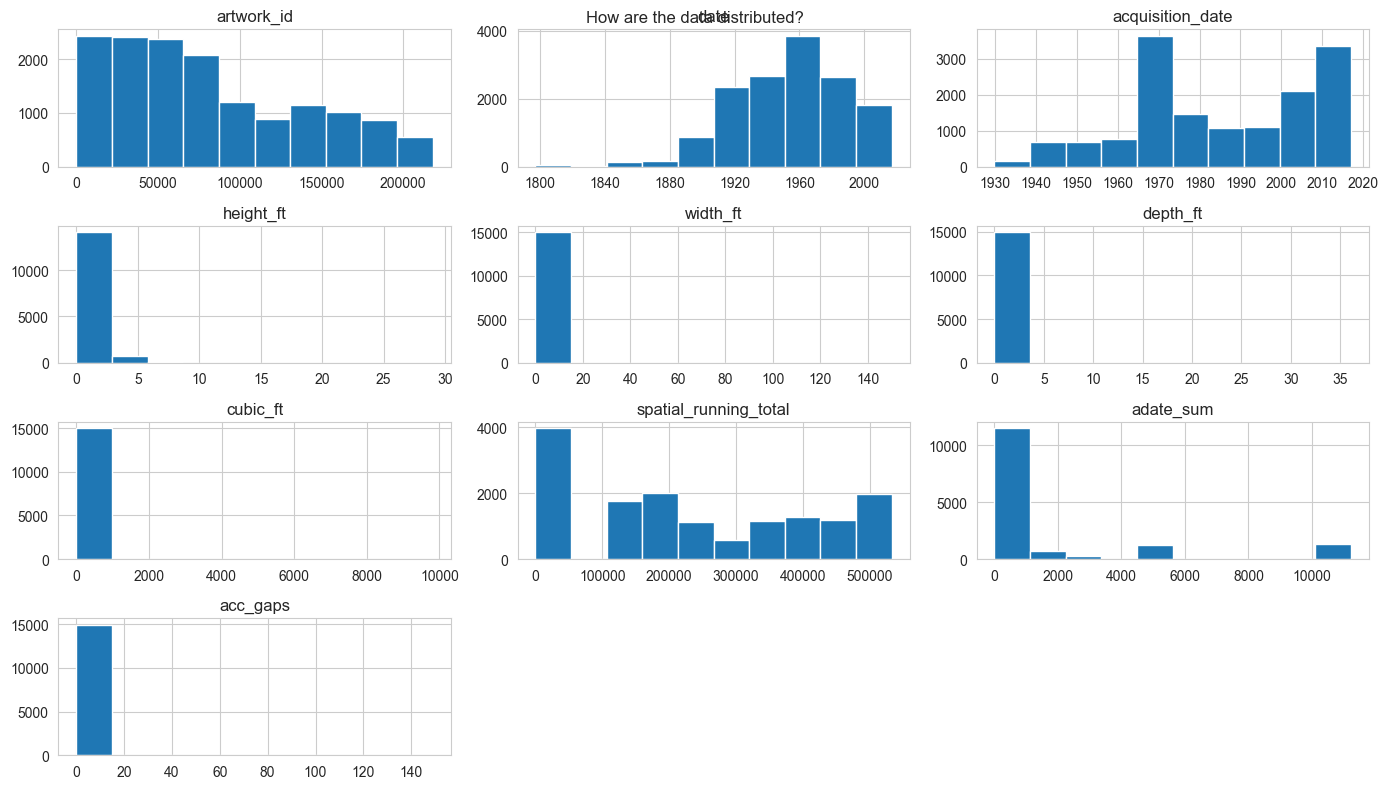

In [11]:
datasets["artworks_data"].hist(
    figsize = (14, 8), 
    # xrot = 90, 
    layout = (4, 3)
)
plt.tight_layout()
plt.suptitle("How are the data distributed?\n")


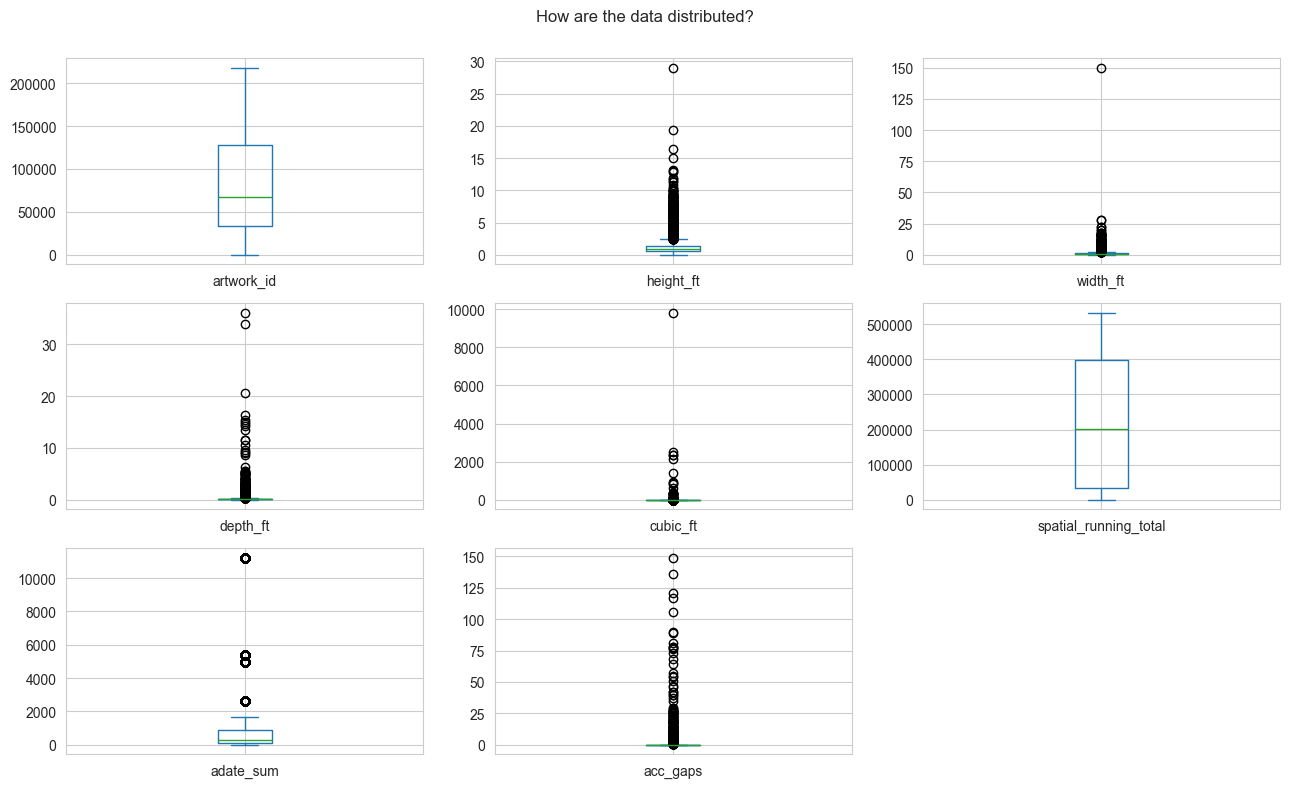

In [12]:
datasets["artworks_data"].plot(
    figsize=(13, 8), 
    kind="box", 
    subplots=True, 
    layout=(3, 3)
);
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()

In [13]:
# TODO: Display which Object Numbers are connected to spatial outliers

plotted_columns = ["artwork_id"] + spatial_columns + ["adate_sum"]
outliers = detect_IQR_outliers(datasets["artworks_data"][plotted_columns])

Columns which contain outliers outside of the 25th and 75th percentiles:
artwork_id               False
height_ft                 True
width_ft                  True
depth_ft                  True
cubic_ft                  True
spatial_running_total    False
adate_sum                 True
dtype: bool


<section id="ts-analysis">
    <h2>Collections Time Series Analysis</h2>
</section>

Explain here why I use the overall dataset and a subset of the overall dataset. Motivated by having the high-level perspective of overall data integrity, and a more nuanced view for interpreting more recent data for estimation purposes.
<br>

<section id="acc-analysis">
    <h3>Accessions Analysis & Decomposition</h3>
</section>

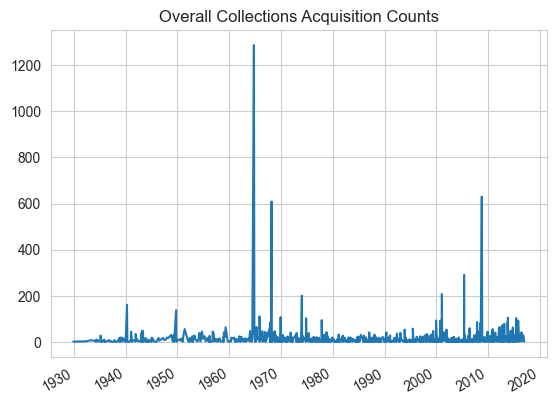

In [14]:
# Accession counts over all-time
datasets["artworks_data"]["acquisition_date"].value_counts().sort_index().plot()
plt.title("Overall Collections Acquisition Counts");

In [15]:
# Table: Accession counts over all-time

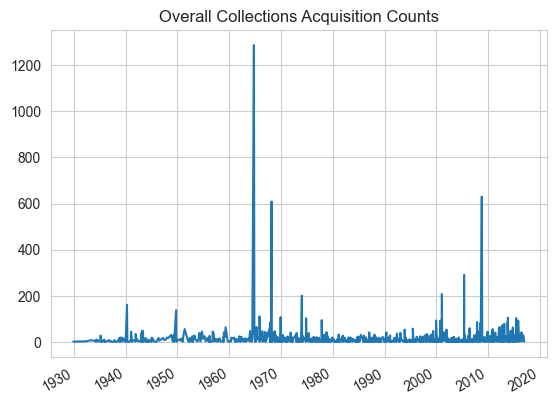

In [16]:
# Accession counts over the last 20 years
datasets["artworks_data"]["acquisition_date"].value_counts().sort_index().plot()
plt.title("Overall Collections Acquisition Counts");

In [17]:
# Table: Accession counts over the last 20 years

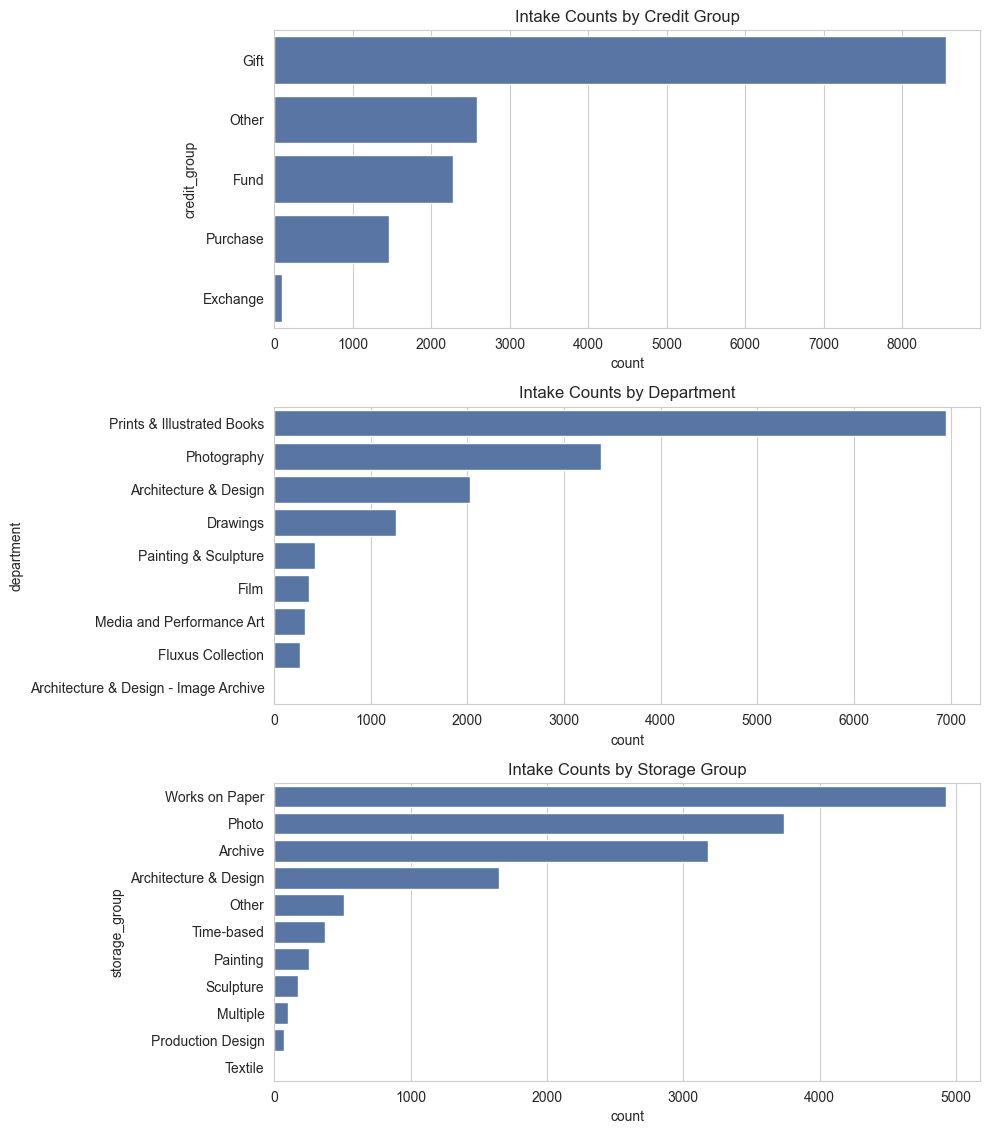

In [18]:
# Overall accession counts by credit, department, and storage group
plt.figure(figsize = (10, 15))
for idx, category in enumerate(POI_categories, 1):
    # Acquistion date counts
    if category != "acquisition_date":
        plt.subplot(4, 1, idx)
        sns.countplot(
            y = category,
            data = datasets["artworks_data"],
            # sorts plots by descending order for visual clarity
            order = datasets["artworks_data"][category].value_counts().index,
            color = sns.color_palette("deep")[0]
        )
        plt.title(f"Intake Counts by {category.replace('_', ' ').title()}")
plt.tight_layout()
plt.show()
    # Only returns the top (head) 15 results,
    # If a category has fewer than 15 unique entries the results are displayed unmodified.
    # print(counts_by(category, artworks_df).head(15), "\n")

In [19]:
# Table: Overall accession counts by credit, department, and storage group

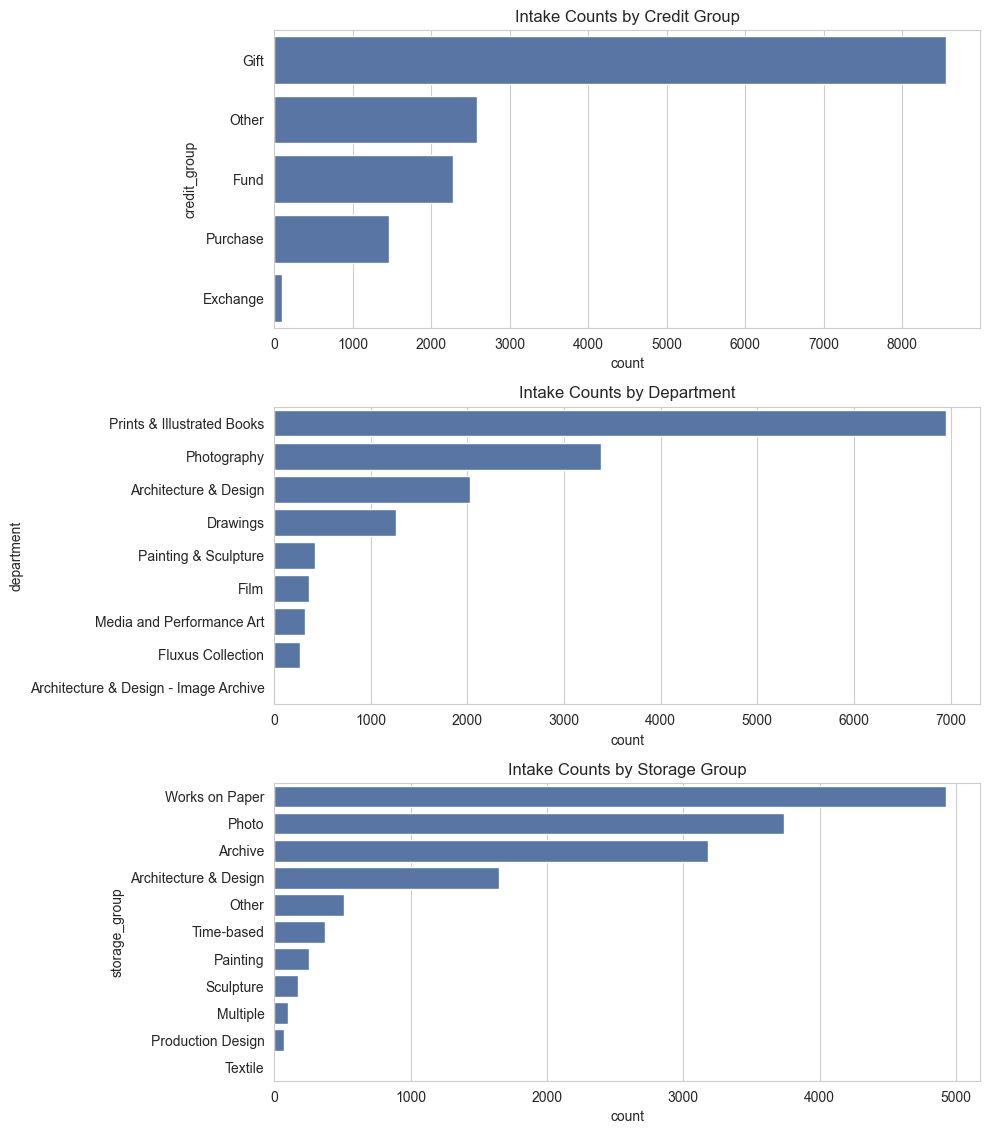

In [20]:
# 20-Year data subset: accession counts by credit, department, and storage group
# Overall accession counts by credit, department, and storage group
plt.figure(figsize = (10, 15))
for idx, category in enumerate(POI_categories, 1):
    # Acquistion date counts
    if category != "acquisition_date":
        plt.subplot(4, 1, idx)
        sns.countplot(
            y = category,
            data = datasets["artworks_data"],
            # sorts plots by descending order for visual clarity
            order = datasets["artworks_data"][category].value_counts().index,
            color = sns.color_palette("deep")[0]
        )
        plt.title(f"Intake Counts by {category.replace('_', ' ').title()}")
plt.tight_layout()
plt.show()
    # Only returns the top (head) 15 results,
    # If a category has fewer than 15 unique entries the results are displayed unmodified.
    # print(counts_by(category, artworks_df).head(15), "\n")

In [21]:
# Table: 20-Year data subset: accession counts by credit, department, and storage group

<section id="gap-analysis">
    <h2>Analysis of Gaps in Acquisition Dates & Backlog Durations - Breakdowns by [Overall, Credit, Dept, Storage_Group]</h2>
</section>

In [34]:
# TODO: Breakdown Accessions by Month of the year, week of the month, and day of the week.
accessions_breakdown_df = gen_ts_features(datasets["artworks_data"], "acquisition_date", ["adate_sum"])
accessions_breakdown_df

,acquisition_date,adate_sum,day_of_week,week_of_month,week_of_year,month_of_year,year
103354,1971-05-04,176,Tuesday,1,18,May,1971
14627,1969-04-16,197,Wednesday,3,16,April,1969
65506,1961-12-13,187,Wednesday,2,50,December,1961
45138,1974-04-02,260,Tuesday,1,14,April,1974
119630,2015-01-29,73,Thursday,5,5,January,2015
...,...,...,...,...,...,...,...
15858,1987-10-20,227,Tuesday,3,43,October,1987
124753,2015-05-28,889,Thursday,4,22,May,2015
9037,1993-01-18,308,Monday,3,3,January,1993
90748,2007-06-05,128,Tuesday,1,23,June,2007


In [ ]:
datasets["artworks_data"].plot(
    x = "date", 
    y = "acquisition_date", 
    kind = "scatter", 
    title = "Are works contemporary when they're acquired?"
);

In [ ]:
# Table: How contemporary are the intake practices of the NYC MoMA?

In [ ]:
# Categorical subset - object_number, credit_group, department, storage_group
# Counts - accession date total, gaps between accessions
(
datasets["artworks_data"][POI_categories + ["object_number", "adate_sum","acc_gaps"]]
    .sort_values(["acc_gaps"], ascending = False)
    .head(20)
)

<section id="spatial-stats">
    <h2>Spatial Descriptive Statistics - Histograms, Boxplots, and Totals by [Overall, Credit, Dept, Storage_Group]</h2>
</section>

In [ ]:
# All spatial columns plotted against each other.
# sns.pairplot(
#     data = datasets["artworks_data"],
#     vars = ["height_ft", "width_ft", "depth_ft", "cubic_ft"], 
#     corner = True
# )

## Conclusions & Recommendations

I will add thinking for how to go about forecasting given our analysis. All of that will be added in this section, which doubles as a high-level overview of the forecasting approach.

Models in consideration:
MA, ES, CROSTON w/SBA, H-CROSTON w/SBA, TBS

Why:
Given that our professional working assumption is that our data as accession-only and accessions counts cannot go below zero, it's necessary to model the data as a "Intermittent Demand-side Forecasting" problem. Borrowing from the field of predictive inventory analytics, this approach allows us to model influxes of objects in a collection without necessitating deaccession data to make predictions about collections growth. In live projects with MMM clients, we anticipate having more flexibility in our model selection processes (because we're not actually working with the MoMA, just their data). As the stand-in for our collections professional client, Samantha, had put forward that they would like to understand any hierarchical relationships within the dataset such as object counts by department and storage group as they filter up to inform the overall total of incoming works.  

What:
For our forecasting process, we will be comparing a couple of standard statistical models to more specified predictive techniques. The client's desired analysis outcomes indicate to me that we will be prioritizing bottom-up hierarchical models which have been designed to perform well in predicting intermittent, incoming quantities. Each of the statistical models have accompanying metrics which describe various aspects of their predictive performance, for the purposes of this demonstration analysis we will be using the following metrics: MSE, RMSE, MAD, etc.